# Predictive Policing in SF - a toy WMD

## For a blog post explaining the motivation behind this project and an interactive map with the predictions visit:

 http://www.orlandotorres.org/predictive-policing-sf.html

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

pd.options.mode.chained_assignment = None

In [2]:
crime17 = pd.read_csv('sf_incidents17.csv')
crime16 = pd.read_csv('sf_incidents16.csv')


### Find the zip codes for each incident given the latitude and longitude

In [3]:
crime16['geometry'] = crime16.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [4]:
geo_police_data = geopandas.GeoDataFrame(crime16, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

In [5]:
sf = geopandas.read_file('zipcodes.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')

In [6]:
crime16 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [7]:
day_time_zip_16 = crime16[['Date', 'DayOfWeek', 'Time', 'zip']]

In [8]:
day_time_zip_16.loc[:, 'Date'] = pd.to_datetime(day_time_zip_16['Date'])

day_time_zip_16.loc[:, 'Hour'] = pd.to_datetime(day_time_zip_16['Time'])
day_time_zip_16.loc[:, 'Hour'] = day_time_zip_16.Hour.apply(lambda x: x.hour)

In [9]:
day_time_zip_16.head()

,Date,DayOfWeek,Time,zip,Hour
0,2016-01-29,Friday,11:00,94103,11
1,2016-01-29,Friday,11:00,94103,11
2,2016-02-18,Thursday,22:00,94109,22
3,2016-10-03,Monday,01:18,94102,1
4,2016-04-25,Monday,14:59,94124,14


## Remove data from November and December because I don't have that data for 2017 to compare it to

In [10]:
day_time_zip_16_final = day_time_zip_16[day_time_zip_16.Date.dt.month < 11]

## Combine all the crimes into hours and days and zip codes

In [11]:
day_time_zip_16_final = day_time_zip_16[['DayOfWeek', 'zip', 'Hour']]

In [12]:
day_time_zip_16_final.loc[:, 'Crimes'] = 1

In [13]:
hour_totals_16 = day_time_zip_16_final.groupby(['DayOfWeek', 'zip', 'Hour']).sum().reset_index()

In [14]:
hour_totals_16.sort_values('Crimes', ascending = False).head()

,DayOfWeek,zip,Hour,Crimes
41,Friday,94103,17,265
650,Monday,94103,17,258
2482,Thursday,94103,18,257
3699,Wednesday,94103,18,257
42,Friday,94103,18,253


## Create dummy variables to start doing analysis

In [15]:
hour_totals_16 = hour_totals_16[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

In [16]:
totals_dummies_16 = pd.get_dummies(hour_totals_16)

In [17]:
X_16 = totals_dummies_16.iloc[:, 1:]
y_16 = totals_dummies_16.iloc[:, 0]

## Linear Regression with 2016 data

In [18]:
linear_regression = sm.OLS(y_16, X_16)
results = linear_regression.fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     416.8
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        14:19:36   Log-Likelihood:                -18432.
No. Observations:                4262   AIC:                         3.693e+04
Df Residuals:                    4229   BIC:                         3.714e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Hour                    1.4119      0.041     34.673      0.000       1.332       1.492
DayOfWeek_Friday       17.4704      0.813     21.484      0.000      15.876      19.065
DayOfWeek_Monday       13.2707      0.815     16.281      0.000      11.673      14.869
DayOfWeek_Saturday     15.4647      0.813     19.017      0.000      13.870      17.059
DayOfWeek_Sunday       12.2682      0.809     15.159      0.000      10.682      13.855
DayOfWeek_Thursday     14.1285      0.814     17.355      0.000      12.532      15.725
DayOfWeek_Tuesday      13.8876      0.815     17.037      0.000      12.290      15.486
DayOfWeek_Wednesday    14.0806      0.817     17.232      0.000      12.479      15.683
zip_94102              60.7649      1.393     43.616      0.000      58.034      63.496
zip_94103             113.8006      1.393     81.684      0.000     111.069     116.532
zip_94104             -26.1413      1.474    -17.729      0.000     -29.032     -23.250
zip_94105             -11.3363      1.393     -8.137      0.000     -14.068      -8.605
zip_94107              12.9018      1.393      9.261      0.000      10.170      15.633
zip_94108              -7.8244      1.393     -5.616      0.000     -10.556      -5.093
zip_94109              35.1161      1.393     25.206      0.000      32.385      37.847
zip_94110              51.0625      1.393     36.652      0.000      48.331      53.794
zip_94111             -13.1844      1.410     -9.349      0.000     -15.949     -10.420
zip_94112               9.2530      1.393      6.642      0.000       6.522      11.984
zip_94114              -1.1756      1.393     -0.844      0.399      -3.907       1.556
zip_94115               7.2173      1.393      5.180      0.000       4.486       9.949
zip_94116             -14.4038      1.402    -10.277      0.000     -17.152     -11.656
zip_94117               3.0863      1.393      2.215      0.027       0.355       5.818
zip_94118              -6.7529      1.393     -4.847      0.000      -9.484      -4.022
zip_94121             -11.1970      1.406     -7.965      0.000     -13.953      -8.441
zip_94122              -2.2113      1.393     -1.587      0.113      -4.943       0.520
zip_94123              -8.8429      1.397     -6.328      0.000     -11.582      -6.103
zip_94124              20.7411      1.393     14.888      0.000      18.010      23.472
zip_94127             -23.5779      1.432    -16.462      0.000     -26.386     -20.770
zip_94130             -29.4819      1.658    -17.786      0.000     -32.732     -26.232
zip_94131             -18.0510      1.410    -12.802      0.000     -20.815     -15.287
zip_94132             -11.4256      1.393     -8.201      0.000     -14.157      -8.694
zip_94133               7.7113      1.393      5.535      0.000       4.980      10.443
zip

# Test it with new 2017 data

### Find the zip codes for each incident given the latitude and longitude

In [20]:
crime17['geometry'] = crime17.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [21]:
geo_police_data = geopandas.GeoDataFrame(crime17, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

In [22]:
sf = geopandas.read_file('zipcodes.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')

In [23]:
crime17 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [24]:
day_time_zip_17 = crime17[['DayOfWeek', 'Time', 'zip']]

In [25]:
day_time_zip_17['Hour'] = pd.to_datetime(day_time_zip_17['Time'])
day_time_zip_17['Hour'] = day_time_zip_17.Hour.apply(lambda x: x.hour)

## Combine all the crimes into hours and days and zip codes

In [26]:
day_time_zip_17 = day_time_zip_17[['DayOfWeek', 'zip', 'Hour']]

In [27]:
day_time_zip_17['Crimes'] = 1

In [28]:
hour_totals_17 = day_time_zip_17.groupby(['DayOfWeek', 'zip', 'Hour']).count().reset_index()

In [29]:
hour_totals_17.sort_values('Crimes', ascending = False).head()

,DayOfWeek,zip,Hour,Crimes
2465,Thursday,94103,18,227
2466,Thursday,94103,19,220
41,Friday,94103,17,213
3067,Tuesday,94103,18,213
44,Friday,94103,20,201


## Create dummy variables to start doing analysis

In [30]:
hour_totals_17 = hour_totals_17[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

In [31]:
totals_dummies_17 = pd.get_dummies(hour_totals_17)

In [32]:
X_17 = totals_dummies_17.iloc[:, 1:]
y_17 = totals_dummies_17.iloc[:, 0]

# Testing the different models

## Linear Regression

In [33]:
linear_regression = LinearRegression()
linear_regression.fit(X_16,y_16)
linear_regression.score(X_17, y_17)

0.63869178372506186

## Random Forest

In [34]:
rf = RandomForestRegressor()
rf.fit(X_16, y_16)
rf.score(X_17,y_17)

0.8015309961966165

In [35]:
list(zip(X_16.columns, rf.feature_importances_))

[('Hour', 0.2482365700124422),
 ('DayOfWeek_Friday', 0.0073801529197892821),
 ('DayOfWeek_Monday', 0.0033864829996435612),
 ('DayOfWeek_Saturday', 0.0086689423045031334),
 ('DayOfWeek_Sunday', 0.0094371314995153107),
 ('DayOfWeek_Thursday', 0.0041752495553263056),
 ('DayOfWeek_Tuesday', 0.0034712166547814457),
 ('DayOfWeek_Wednesday', 0.0044772433550702741),
 ('zip_94102', 0.11144061897624913),
 ('zip_94103', 0.34308077568242618),
 ('zip_94104', 0.0072715892658153482),
 ('zip_94105', 0.00081952084068086033),
 ('zip_94107', 0.015011607005189515),
 ('zip_94108', 0.00084906419390489633),
 ('zip_94109', 0.049537113633621468),
 ('zip_94110', 0.082983215249074677),
 ('zip_94111', 0.00055811826116040897),
 ('zip_94112', 0.011167793167368326),
 ('zip_94114', 0.002722784210736442),
 ('zip_94115', 0.010314461956881179),
 ('zip_94116', 0.00072026828041189318),
 ('zip_94117', 0.0078058207898623793),
 ('zip_94118', 0.00096821246980150215),
 ('zip_94121', 0.00050669132196624292),
 ('zip_94122', 0.00

## KNN

In [36]:
knn = KNeighborsRegressor()
knn.fit(X_16, y_16)
knn.score(X_17,y_17)

0.71291747352224233

## SVM

In [37]:
svm = SVR()
svm.fit(X_16, y_16)
svm.score(X_17,y_17)

0.21479510610828201

## XGBoost

In [38]:
xgb = XGBRegressor()
xgb.fit(X_16, y_16)
xgb.score(X_17,y_17)

0.83361380920457129

## MLP Regressor

In [39]:
mlp = MLPRegressor(hidden_layer_sizes = (100,100,100,100), random_state=444)
mlp.fit(X_16,y_16)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=444,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [40]:
mlp.score(X_17, y_17)

0.86872151340190129

## Combine predictions and actual results into one dataframe

In [41]:
mlp_predicts = mlp.predict(X_16)

In [42]:
xgb_predicts = xgb.predict(X_16)

In [43]:
hour_totals_17['Predicted_mlp'] = pd.Series(mlp_predicts)
hour_totals_17['Predicted_xgb'] = pd.Series(xgb_predicts)

### Divide by 365 to get the number of crime incidents each day

In [44]:
hour_totals_17['Crimes'] = hour_totals_17['Crimes']/365
hour_totals_17['Predicted_mlp'] = hour_totals_17['Predicted_mlp']/365
hour_totals_17['Predicted_xgb'] = hour_totals_17['Predicted_xgb']/365


In [45]:
hour_totals_17 = np.round(hour_totals_17,2)

In [46]:
hour_totals_17.to_json("./colombia/crime_predictions.json", orient='records', double_precision=2)

## Create a quick Chloropleth map as a sanity check

In [47]:
chloropleth_data = hour_totals_17.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}

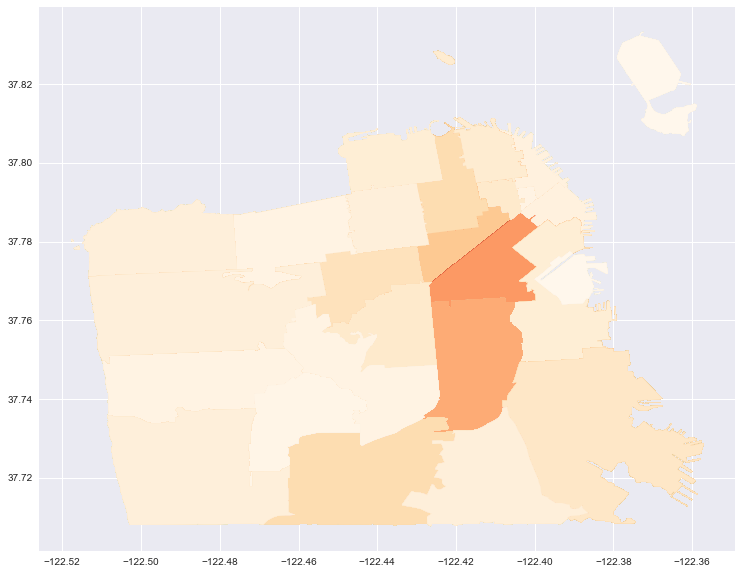

In [48]:
chloropleth_data.plot(column='Crimes', cmap='OrRd', figsize=(13,10))

### The next step is to make an interactive visualization. For this, I will move to D3.js